
## 外れ値エンジニアリング


外れ値とは、残りのデータとは大きく異なるデータポイントのことです。"外れ値とは、別のメカニズムで生成されたのではないかという疑念を抱かせるほど、他の観測結果から大きく逸脱している観測結果のことです。" [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980]とあります。

平均値や分散などの統計は、外れ値の影響を非常に受けやすい。また、**機械学習のモデルの中には、外れ値に敏感なものがあり**、性能が低下することがあります。そのため、学習したいアルゴリズムに応じて、変数から外れ値を取り除くことがよくあります。

本コースのセクション3では、外れ値を特定する方法を説明しました。このセクションでは、機械学習モデルを学習するために、外れ値をどのように処理するかを説明します。


## どのようにして外れ値を前処理するのか？

- トリミング：データセットから外れ値を取り除く
- 外れ値を欠落データとして扱い、欠落データの入力技術を進める。
- Discrestisation: 外れ値を分布の高い値や低い値と一緒にボーダービンに入れる。
- 打ち切り：変数の分布の最大値または最小値に上限を設定する。

**打ち切り**は次のようにも呼ばれます。

- トップ＆ボトムコーディング
- winsorization
- キャッピング


## Trimming or truncation

トリミング（トランケーションとも呼ばれる）は、データセットから外れ値を取り除くことである。外れ値を決定するための指標を決めるだけです。第3節で見たように、これは正規分布した変数の場合はガウス近似、歪んだ変数の場合は分位値間範囲近接則となります。

### 利点

- 速い

### 制限事項

- ある変数の外れ値には、他の変数の有用な情報が含まれている可能性があります。
- 多くの変数に外れ値がある場合、データセットの大きな塊を取り除くことができる。

## このデモでは

Boston Houseデータセットを使用してトリミングを行う方法を見てみましょう。

## 重要事項

はずれ値を検出し、トレーニングセットからのみ**削除し、テストセットからは削除しないこと。

そのため、まずデータセットを訓練とテストに分け、訓練セットでは外れ値を除去し、テストセットでは外れ値を残して、モデルの出来を測定する必要があります。

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Q-Qプロット用
import scipy.stats as stats

# デモ用ボストンハウスデータセット
from sklearn.datasets import load_boston

In [2]:
# ボストンの住宅価格のデータを読み込む

# sklearnからボストンのデータセットを読み込む
boston_dataset = load_boston()


# 独立変数でデータフレームを作成する
# このデモでは、全変数のうち3つだけを使用します
boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

#ターゲットの追加
boston['MEDV'] = boston_dataset.target

boston.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [5]:
# ヒストグラム，Q-Qプロット，ボックスプロットを作成する # 関数です．
# boxplotを作成する関数です。講座のセクション3で学びました


def diagnostic_plots(df, variable):
    # この関数は、データフレーム(df)と対象となる変数を引数として # 受け取ります。
    # 対象となる変数を引数として受け取ります。

    # 図形サイズの定義
    plt.figure(figsize=(16, 4))

    # ヒストグラム
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Qプロット
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # 箱ひげ図
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()


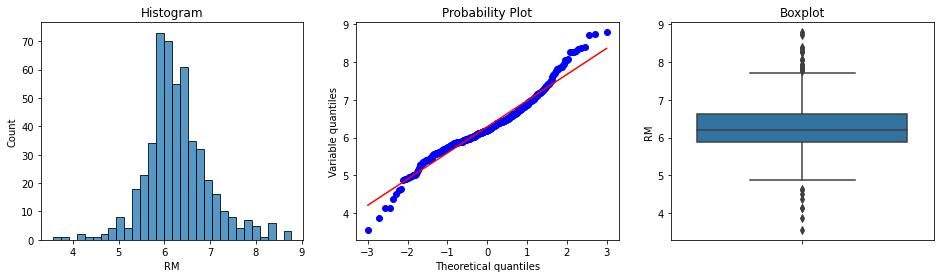

In [6]:
# RMの外れ値を見つけよう

diagnostic_plots(boston, 'RM')

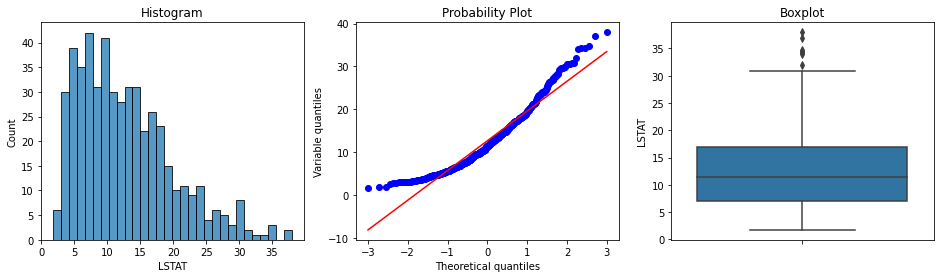

In [7]:
# LSTATで外れ値を可視化する

diagnostic_plots(boston, 'LSTAT')

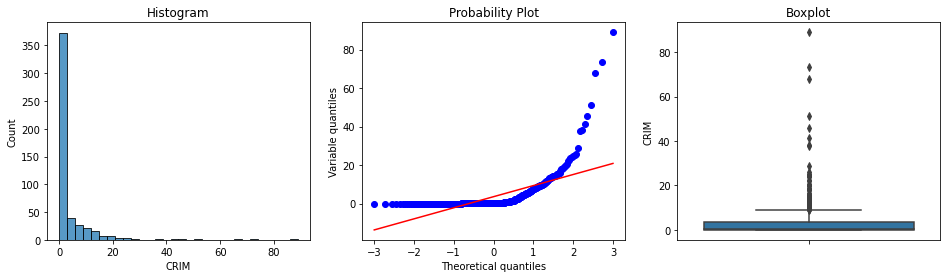

In [8]:
# CRIMでの外れ値

diagnostic_plots(boston, 'CRIM')

上記のすべての変数に外れ値があります。RMは両テールに外れ値を示していますが、LSTATとCRIMは右テールにのみ示しています。

外れ値を見つけるために、第3節で学んだ関数を再利用してみましょう。


In [9]:
def find_skewed_boundaries(df, variable, distance):


    # 外れ値が存在する境界を計算しよう
    # 歪んだ分布の場合

    # distanceを引数として渡すと、次のようなオプションが得られます。
    # IQRの1.5倍または3倍を推定して計算します。
    # 境界線を計算します。



    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [10]:
# RMの限界値を求める

RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730499999999999, 4.778500000000001)

In [11]:
# LSTATの限界値を求める

LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

In [12]:
# CRIMの限界値

CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

In [13]:
# データセットの外れ値にフラグを立てよう

outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))

In [14]:
# データセットをトリミングしてみよう

outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

In [15]:
# データセットの外れ値にフラグを立てよう

outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

In [16]:
# データセットをトリミングしよう

boston_trimmed = boston.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM), ]

boston.shape, boston_trimmed.shape

((506, 4), (416, 4))

トリミングによって、500行のデータセットから約100行が削除され、データの約20%が削除されたことがわかります。これが、機械学習でトリミングをあまり使わない理由です。しかし、少数の変数にわずかな割合で異常値が存在する場合は、トリミングが有効です。

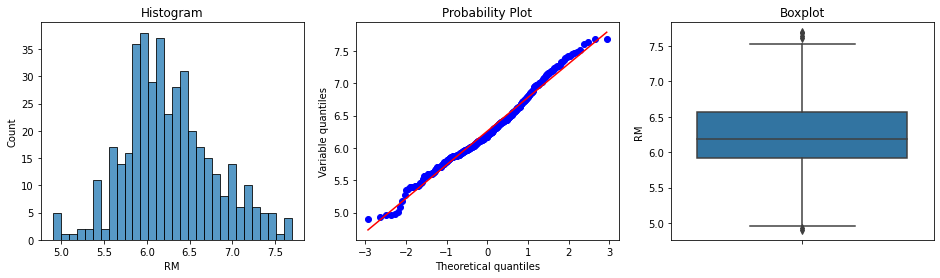

In [17]:
# トリミングしたデータセットの外れ値を調べてみましょう。
# RMの場合、元のデータセットに比べて外れ値が非常に少ないことがわかります。


diagnostic_plots(boston_trimmed, 'RM')

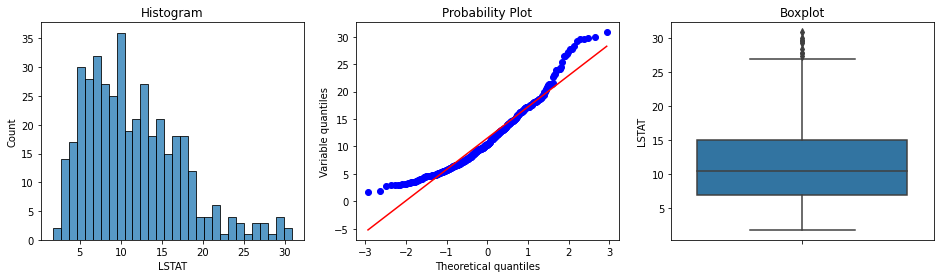

In [18]:
diagnostic_plots(boston_trimmed, 'LSTAT')

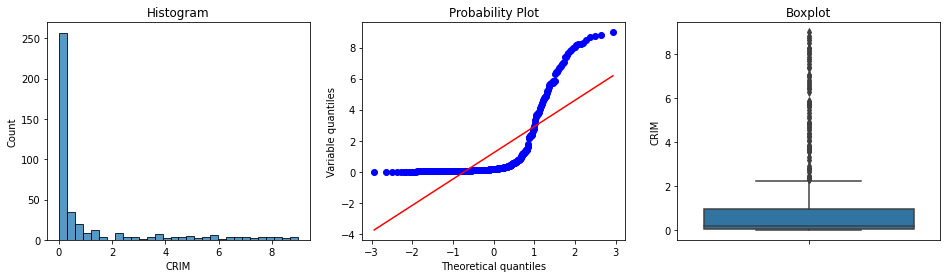

In [19]:
diagnostic_plots(boston_trimmed, 'CRIM')


LSTATとCRIMについては、まだ多くの外れ値が見られます。データセットからデータポイントを削除すると、分布のすべてのパラメータが再計算されます。それらは、平均、分位数、分位数間の範囲です。したがって、新しい「トリミング」された変数では、以前は外れ値とは見なされなかった値が、今では外れ値と見なされます。

これは外れ値に対処するこの方法の望ましくない特徴です。

## New: Feature-engineによる外れ値のトリミング

Feature-engine で外れ値をトリミングする方法については、ドキュメントを参照してください。

https://feature-engine.readthedocs.io/en/latest/outliers/OutlierTrimmer.html
